# *lenstronomy* starting guide

With this notebook, we describe the basic functionalities of the most important modules of *lenstronomy* with some simple examples. More detailed information about the available routines and their use can be accessed through the online documentation and in other jupyter notebooks.

In [1]:
# some standard python imports #
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

## $\texttt{LensModel}$ module
$\texttt{LensModel}$ and its sub-packages execute all the purely lensing related tasks of *lenstronomy*. This includes ray-shooting, solving the lens equation, arrival time computation and non-linear solvers to optimize lens models for specific image configurations. The module allows consistent integration with single and multi plane lensing and an arbitrary superpositions of lens models. There is a wide range of lens models available. For details we refer to to the online-documentation.

### Single plane lensing
As an example of initializing a single plane lens model as a super-position of an elliptical power-law potential and a singular isothermal sphere mass distribution and execute some basic routines:

In [2]:
# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SPEP', 'SHEAR']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_spep = {'theta_E': 1.1, 'e1': 0.05, 'e2': 0.05, 'gamma': 2., 'center_x': 0.1, 'center_y': 0}
kwargs_shear = {'gamma1': -0.01, 'gamma2': .03}
kwargs_lens = [kwargs_spep, kwargs_shear]


# image plane coordinate #
theta_ra, theta_dec = .9, .4

# source plane coordinate #
beta_ra, beta_dec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)
# Fermat potential #
fermat_pot = lensModel.fermat_potential(x_image=theta_ra, y_image=theta_dec, x_source=beta_ra, y_source=beta_dec, kwargs_lens=kwargs_lens)

# Magnification #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

Additionally, the $\texttt{LensModel}$ class allows to compute the Hessian matrix, shear and convergence, deflection angle and lensing potential. These routines are fully compatible with the numpy array structure and as a superposition of an arbitrary number of single lens models.

### Multi-plane lensing

The multi-plane setting of $\texttt{LensModel}$ allows to place the different deflector models at different redshifts. When not further specified, the default cosmology of the $\texttt{astropy}$ cosmology class. The interface to access the lensing functionalities remains the same.
In this example we add an additional Singular Isothermal Sphere (SIS) model at a different redshfit.

In [3]:
# keep the imports and variables from above #
# specify redshifts of deflectors #
redshift_list = [0.5, 0.5, .1]
# specify source redshift #
z_source = 1.5
# setup lens model class with the list of lens models #
lens_model_list_mp = ['SPEP', 'SHEAR', 'SIS']
lensModel_mp = LensModel(lens_model_list=lens_model_list_mp, z_source=z_source, lens_redshift_list=redshift_list, multi_plane=True)

kwargs_sis = {'theta_E': 0.1, 'center_x': 1., 'center_y': -0.1}
kwargs_lens_mp = [kwargs_spep, kwargs_shear, kwargs_sis]

# source plane coordinate #
beta_ra, beta_dec = lensModel_mp.ray_shooting(theta_ra, theta_dec, kwargs_lens_mp)

# Magnification #
mag = lensModel_mp.magnification(theta_ra, theta_dec, kwargs_lens_mp)

# arrival time relative to a straight path through (0,0) #
dt = lensModel_mp.arrival_time(theta_ra, theta_dec, kwargs_lens_mp)

### lens equation solver

Solving the lens equation to compute the (multiple) image positions of a given source position can be conveniently performed within $\texttt{LensModel}$ and is supported with a general instance of the $\texttt{LensModel}$ class.

In [4]:
# keep the imports and variables from above #
# import the lens equation solver class #
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

# the magnification of the point source images #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

### illustration of lens models
The lens models can be conveniently illustrated with routines present in the $\texttt{Plot}$ module. As an option, you can plot the critical curves and caustics, which are computationally the most demanding part.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


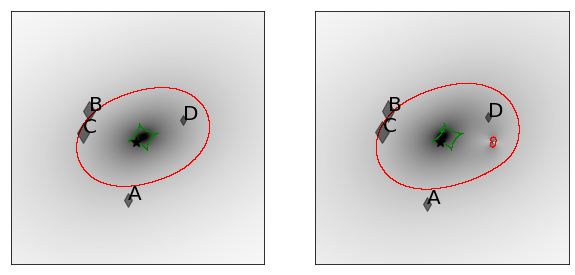

In [5]:
from lenstronomy.Plots import lens_plot
f, axex = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex[0], lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True)
lens_plot.lens_model_plot(axex[1], lensModel=lensModel_mp, kwargs_lens=kwargs_lens_mp, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True)
f.show()

## $\texttt{LightModel}$ module

The $\texttt{LightModel}$ class provides the functionality to describe galaxy surface brightnesses. $\texttt{LightModel}$ supports various analytic profiles as well as representations in shapelet basis sets. Any superposition of different profiles is allowed.

The parameter levelig the amplitude of the surface brightness of a certain profile is named 'amp'. The units are not further specified and are effectively reflecting a surface brightness quantitiy integrated over the unit of angle square. In the $\texttt{SimulationAPI}$ module, the user can conveniently chose astronomical magnitudes as inputs to the profiles, provided the magnitude zero point is declared. Have a look at the specific notebook to see a demonstration.

In [6]:
# import the LightModel class #
from lenstronomy.LightModel.light_model import LightModel
# set up the list of light models to be used #
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)
# define the parameters #
kwargs_light_source = [{'amp': 100, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]
import lenstronomy.Util.param_util as param_util
e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)
kwargs_light_lens = [{'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.1, 'center_y': 0}]

# evaluate surface brightness at a specific position #
flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

## $\texttt{PointSource}$ module
To accurately predict and model the positon and flux of point sources, one has to apply different numerical procedures than for extended surface brightness features. The $\texttt{PointSource}$ class manages the different options in describing point sources (e.g. in the image plane or source plane, with fixed magnification or allowed with individual variations thereof) and provides a homogeneous interface to access image positions and magnifications.

In [7]:
# import the PointSource class #
from lenstronomy.PointSource.point_source import PointSource

# unlensed source positon #
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[True])
kwargs_ps = [{'ra_source': beta_ra, 'dec_source': beta_dec, 'source_amp': 100}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

# lensed image positions (solution of the lens equation) #
point_source_model_list = ['LENSED_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[False])
kwargs_ps = [{'ra_image': theta_ra, 'dec_image': theta_dec, 'point_amp': np.abs(mag)*30}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

## $\texttt{Data}$ module
The $\texttt{PixelGrid}$ class stores and manages the coordinate frame and. the coordinate-to-pixel transformation necessary to simulate images.
The $\texttt{PSF}$ class handles the point spread function convolution. Supported are pixelized convolution kernels as well as some analytic profiles.

The $\texttt{Data}$ class inherits the $\texttt{PixelGrid}$ and in addition manages data specific quantities (pixel values and noise properties) that are required when fitting models to data to estimate the likelihood of the data given a model. To simulate a mock lens, we only require an instance of the $\texttt{PixelGrid}$ and $\texttt{PSF}$ class.

In [8]:
# import the PixelGrid() class #
from lenstronomy.Data.pixel_grid import PixelGrid
deltaPix = 0.05  # size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.1,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source

## $\texttt{ImSim}$ module
The $\texttt{ImSim}$ module simulates images. At its core is the $\texttt{ImageModel}$ class. It is the interface to combine all the different components, $\texttt{LensModel}$, $\texttt{LightModel}$, $\texttt{PointSource}$ and $\texttt{Data}$ to model images. The $\texttt{LightModel}$ can be used to model lens light (unlensed) or source light (lensed). $\texttt{ImSim}$ is fully supporting all functionalities in each component. Additionaly, numerical precision arguments can be set in how to model the image.

### Simulate image
We simulate an image with an instance of $\texttt{ImageModel}$ that got instances of the classes we created above. We can define two different $\texttt{LightModel}$ instances for the lens and source light. Additionally, we can define the sub-pixel ray-tracing resolution and whether the PSF convolution is applied on the higher resolution ray-tracing image or on the degraded pixel image.

In this example, we do not simulate point source. You can look at the notebooks dedicated to model quads and doubles and also for time-delya cosmography.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


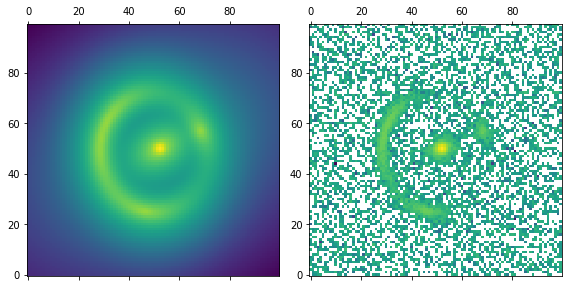

In [9]:
# import the ImageModel class #
from lenstronomy.ImSim.image_model import ImageModel
# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

# we can also add noise #
import lenstronomy.Util.image_util as image_util
exp_time = 100  # exposure time to quantify the Poisson noise level
background_rms = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
axes[0].matshow(np.log10(image), origin='lower')
axes[1].matshow(np.log10(image_noisy), origin='lower')
f.tight_layout()
plt.show()

### Linear inversion
Parameter corresponding to an an amplitude of a surface brightness distribution have a linear response on the predicted flux values in the data and can be infered by a linear inversion. This can reduce the number of non-linear parameters fastly, depending on the source complexity to be modelled.

The $\texttt{ImageLinearFit}$ class performs this computation. The class inherits the $\texttt{ImageModel}$ class but instead of the $\texttt{PixelGrid}$ instance, it requires an instance of the full $\texttt{ImageData}$ class including the data (which we use the mock image created above) and the noise properties therof.

In the example of this notebook, we have 6 linear parameters, the 4 point source amplitudes and the amplitudes of the Sersic profile of the lens and source. *lenstronomy* automatically identifies those parameters and can recover those values (data permitting).


In [10]:
from lenstronomy.Data.imaging_data import ImageData
# update the data with the noisy image and its noise properties #
kwargs_data = {'image_data': image_noisy,
               'background_rms': background_rms,
               'exposure_time': exp_time,
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

data_class = ImageData(**kwargs_data)

from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
image_linear_fit = ImageLinearFit(data_class=data_class, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics)

# we do not require the knowledge of the linear parameters #
del kwargs_light_source[0]['amp']
# apply the linear inversion to fit for the noisy image #
image_reconstructed, _, _, _ = image_linear_fit.image_linear_solve(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source, 
                              kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

-0.9997441102908949 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9997441102908949


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:86: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


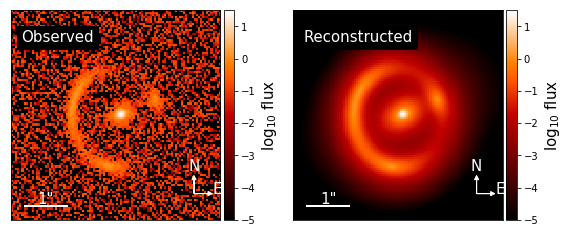

In [11]:
# illustrate fit #
from lenstronomy.Plots.model_plot import ModelPlot
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_light_model_list,
               'lens_light_model_list': lens_light_model_list} #, 'point_source_model_list': point_source_model_list}
kwargs_params = {'kwargs_lens': kwargs_lens, 'kwargs_source': kwargs_light_source,
                 'kwargs_lens_light': kwargs_light_lens, 'kwargs_ps': kwargs_ps}
lensPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_params, arrow_size=0.02)

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
lensPlot.data_plot(ax=axes[0])
lensPlot.model_plot(ax=axes[1])
f.tight_layout()
plt.show()

## $\texttt{Sampling}$ Module
The $\texttt{Sampling}$ Module consists of threee major classes: The $\texttt{Likelihood}$ class manages the specific likelihood function, consisting of the imaging likelihood and potential other data and constraints. The $\texttt{Param}$ class handles all the model choices and the parameters going in it. These classes handle all the model choices of the user and mitigate them to the external modules and from the external modules back to *lenstronomy*.

The $\texttt{Sampler}$ class gives specific examples how the $\texttt{Likelihood}$ and $\texttt{Param}$ classes can be used to execute specific samplers. This last class can also be replaced by other sampling methods by the user.


### $\texttt{Param}$ class
The $\texttt{Param}$ class is the interface of the *lenstronomy* conventions of parameters (list of keyword arguments) and the fitting conventions of $\texttt{CosmoHammer}$ or $\texttt{emcee}$ (single array consisting all parameters). The $\texttt{Param}$ class enables the user to set further options:

- keep certain parameters fixed
- handling of the linear parameters
- provide additional constraints on the modelling (e.g. fix source profile to point source position etc)

With the $\texttt{Param}$ class, lenstronomy can be integrated robustly with other sampling methods.


<div class="alert alert-warning">

**ATTENTION:** Parameters called 'amp' are inferred during each step of the sampling with a linear equation rather than explicitly sampled from. So these parameters will not appear in the output (or as amp = 1). To reconstruct the actual values that was used for a specific sample, you need to re-apply the linear inversion step. This is e.g. done when executing the plotting routines.

</div>

In [12]:
# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# set options for constraint parameters #
# Here we join the position of the lens light and mass center. 
# There are more options available in the Param() class.
kwargs_constraints = {'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]]}

# list fixed parameters #
kwargs_fixed_lens = [{'gamma': 2.}, {'ra_0': 0, 'dec_0': 0}, {}]
kwargs_fixed_source = [{}]
kwargs_fixed_lens_light = [{}]

# optional: list lower and upper bounds in parameter space, otherwise it will be using lenstronomy default values! #
# list lower bounds in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
                     {'gamma1': -0.5, 'gamma2': -0.5}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = None

# list upper bounds in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
                     {'gamma1': 0.5, 'gamma2': 0.5}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = None

# make instance of parameter class with given model options, constraints and fixed parameters #
param = Param(kwargs_model, kwargs_fixed_lens, kwargs_fixed_source,
              kwargs_fixed_lens_light, kwargs_fixed_ps=None, 
              kwargs_lower_lens=kwargs_lower_lens, kwargs_lower_source=kwargs_lower_source,
              kwargs_lower_lens_light=kwargs_lower_lens_light, kwargs_lower_ps=kwargs_lower_ps,
              kwargs_upper_lens=kwargs_upper_lens, kwargs_upper_source=kwargs_upper_source,
              kwargs_upper_lens_light=kwargs_upper_lens_light, kwargs_upper_ps=kwargs_upper_ps,
              kwargs_lens_init=kwargs_lens, **kwargs_constraints)

# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

# parameter array for fitting routine #
param_array = param.kwargs2args(kwargs_lens, kwargs_light_source, kwargs_light_lens, kwargs_ps)

# recover keyword arguments list for lenstronomy from a parameter array of the fitting routine #
kwargs_out = param.args2kwargs(param_array)

# print settings #
param.print_setting()


The following model options are chosen:
Lens models: ['SPEP', 'SHEAR']
Source models: ['SERSIC']
Lens light models: ['SERSIC_ELLIPSE']
Point source models: []
The following parameters are being fixed:
Lens: [{'gamma': 2.0, 'center_x': 0, 'center_y': 0}, {'ra_0': 0, 'dec_0': 0}, {}]
Source: [{'amp': 1}]
Lens light: [{'amp': 1}]
Point source: []
Joint parameters for different models
Joint lens with lens: []
Joint lens light with lens light: []
Joint source with source: []
Joint lens with light: [[0, 0, ['center_x', 'center_y']]]
Joint source with point source: []
Joint lens light with point source: []
Number of non-linear parameters being sampled:  15
Parameters being sampled:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
Numbe

### $\texttt{Likelihood}$ class

The $\texttt{Likelihood}$ class performs the likelihood computation. It combines the $\texttt{ImSim}$ module with the $\texttt{Param}$ module. The $\texttt{Likelihood}$ class can evaluate imaging likelihoods, image position and time-delay likelihood with various options. For details we refer to the class documentation.

In [13]:
kwargs_likelihood = {'source_marg': False,
                    'check_matched_source_position': True,
                    'source_position_tolerance': 0.001,}
single_band = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': single_band, 'multi_band_type': 'multi-linear'}

from lenstronomy.Sampling.likelihood import LikelihoodModule
likelihoodModule = LikelihoodModule(kwargs_data_joint, kwargs_model, param_class=param, **kwargs_likelihood)

logL = likelihoodModule.logL(args=param_array)

### $\texttt{Sampler}$ class

The $\texttt{Sampler}$ class performs the sampling of the likelihood. The class requires an instance of the $\texttt{Likelihood}$ class. This class is also meant to showcase the sampling of the *lenstronomy* likelihood. We emphasise that the specific parameter space and complexity may warry significantly and depending on the problem, different approaches can be more efficient.

<div class="alert alert-warning">

**Warning:** This particular example was run with a very small and insufficiently long Particle Swarm Optimization. This is for illustrative purpose only. You need to change the 'n_particles' and 'n_iterations' settings and make sure the PSO is sufficiently converged to draw conclusions from the best fit.

</div>

In [14]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
                    {'gamma1': 0, 'gamma2': 0}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.5, 'e2': 0.5, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
                     {'gamma1': 0.05, 'gamma2': 0.05}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.2, 'e2': 0.2, 'center_x': .1, 'center_y': 0.1}]

param_init = param.kwargs2args(kwargs_lens_init, kwargs_source_init, kwargs_lens_light_init, kwargs_ps=None)
param_sigma = param.kwargs2args(kwargs_lens_sigma, kwargs_source_sigma, kwargs_lens_light_sigma, kwargs_ps=None)

upper_start = np.array(param_init) + np.array(param_sigma)
lower_start = np.array(param_init) - np.array(param_sigma)

from lenstronomy.Sampling.sampler import Sampler
sampler = Sampler(likelihoodModule=likelihoodModule)

result, chain_properties = sampler.pso(n_particles=10, n_iterations=10, lower_start=lower_start, upper_start=upper_start)

kwargs_result = param.args2kwargs(result)


Computing the PSO ...
10
Max iteration reached! Stopping.
-2.7405967311197914 reduced X^2 of best position
-13679.688583384439 logL
9983 effective number of data points
[{'theta_E': 1.2967529164998104, 'gamma': 2.0, 'e1': -0.482810053192794, 'e2': -0.2219187864861435, 'center_x': 0.0840431434623487, 'center_y': 0.010959384288024707}, {'gamma1': -0.027139697465694886, 'gamma2': 0.07494816411269267, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.01264387501659623, 'n_sersic': 0.5004045854769021, 'center_x': 0.16871767895870643, 'center_y': 0.03920942391976402}] source result
[{'amp': 1, 'R_sersic': 0.08650609806731226, 'n_sersic': 1.0180430343420495, 'e1': 0.2814937272425718, 'e2': -0.4797766249189395, 'center_x': 0.0840431434623487, 'center_y': 0.010959384288024707}] lens light result
[] point source result
{} special param result
0.16696786880493164 time used for  PSO


## $\texttt{Workflow}$ Module
The $\texttt{Workflow}$ Module manages the execution of non-linear fitter (in our case the PSO) and the parameter inference (in our case the CosmoHammer emcee). The two main classes are $\texttt{Param}$ and $\texttt{FittingSequence}$. These classes handle all the model choices of the user and mitigate them to the external modules and from the external modules back to *lenstronomy*.


### $\texttt{FittingSequence}$ class

The $\texttt{FittingSequence}$ class allows to perform a PSO and/or MCMC run. The user can run a sequence of fitting routines, applied one after the other with taking the results of the previous routine as an input of the next one. The user can specify (optionaly) to keep one or multiple parameter classes (lens model, source model, lens light model and source model) fixed during the fitting process or parameter inference.

The user further needs to specify:
- define input guess and uncertainties and uncertainties
- hard bounds on parameters
- number of particles and number of iterations being performed by the PSO/MCMC
- enables MPI run through a set of fitting sequences

$\texttt{FittingSequence}$ does not rely on instances of other *lenstronomy* classes. It can be constructed from elements in the form of keyword arguments and lists thereof in the *lenstronomy* conventions. This enables a save and reliable execution of tasks within $\texttt{FittingSequence}$ on non-local platforms, such as high performance clusters.

MPI mode can be set in the initialization of the $\texttt{FittingSequence}$ class. Multi-threading can be set (if available) for each individual sequence in their keyword arguments with 'threadCount'.

In [15]:
lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_fixed_source, kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_light_lens, kwargs_lens_light_sigma, kwargs_fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}

band_list = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = []
multi_band_list.append(band_list)


from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1, 'n_particles': 100, 'n_iterations': 100, 'threadCount': 1}],
                       ['MCMC', {'n_burn': 200, 'n_run': 200, 'walkerRatio': 10, 'sigma_scale': .01, 'threadCount': 1}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9991399150973341 reduced X^2 of best position
-4987.206886208343 logL
9983 effective number of data points
[{'theta_E': 1.1001519363104013, 'gamma': 2.0, 'e1': 0.04464342146659807, 'e2': 0.04584536652946715, 'center_x': 0.0976104227662125, 'center_y': 0.00045013603440028586}, {'gamma1': -0.019285092468713, 'gamma2': 0.023910987896745797, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10747638763244421, 'n_sersic': 1.7536984884785067, 'center_x': -0.0417420290298637, 'center_y': -0.08679768089500142}] source result
[{'amp': 1, 'R_sersic': 0.09457774187005355, 'n_sersic': 2.7873599437232826, 'e1': 0.13803461414120172, 'e2': 0.14974524830688293, 'center_x': 0.0976104227662125, 'center_y': 0.00045013603440028586}] lens light result
[] point source result
{} special param result
51.77588891983032 time used for  PSO


100%|██████████| 400/400 [05:46<00:00,  1.34it/s]

Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  200
Sampling iterations (in current run): 400
348.5259289741516 time taken for MCMC sampling


<div class="alert alert-warning">

**Warning:** This particular example was run with a very small and insufficiently long MCMC chain. This is for illustrative purpose only. You need to change the 'n_burn' and 'n_run' settings and make sure the chains are sufficiently converged to draw conclusions from the posteriors.

</div>

### $\texttt{LensModelPlot}$ class
The $\texttt{LensModelPlot}$ facilitates the plotting of models, comparison with the data etc. This class is also meant to illustrate the post-processing.

-0.9973443047588378 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9973443047588376


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  # This is added back by InteractiveShellApp.init_path()


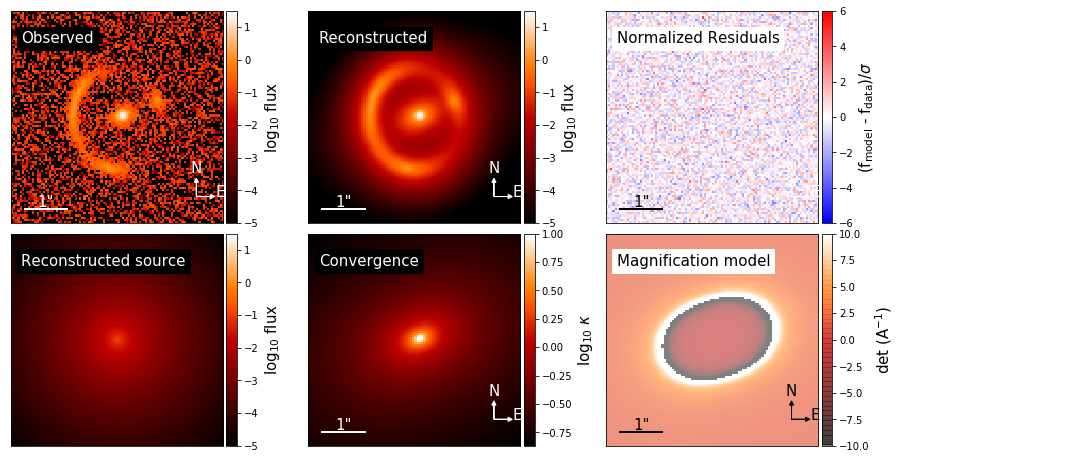

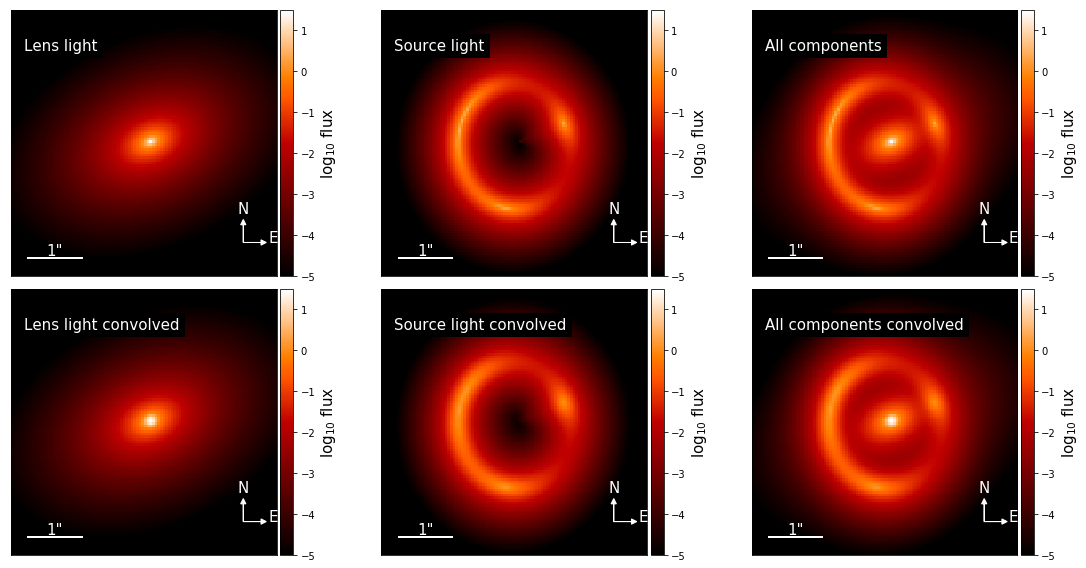

{'kwargs_lens': [{'theta_E': 1.1018117295709613, 'gamma': 2.0, 'e1': 0.04506603348389742, 'e2': 0.04391895375554338, 'center_x': 0.09752383015367617, 'center_y': -0.0004544912796048681}, {'gamma1': -0.01690269240855396, 'gamma2': 0.02219477313997191, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 89.39251002043999, 'R_sersic': 0.10337540617461775, 'n_sersic': 1.6725004348188595, 'center_x': -0.03862657484421047, 'center_y': -0.08673119623401153}], 'kwargs_lens_light': [{'amp': 1060.0491140480265, 'R_sersic': 0.09957045560743799, 'n_sersic': 2.825954053947985, 'e1': 0.13605172875277738, 'e2': 0.1482792058971902, 'center_x': 0.09752383015367617, 'center_y': -0.0004544912796048681}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [16]:

modelPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  15
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  30000


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


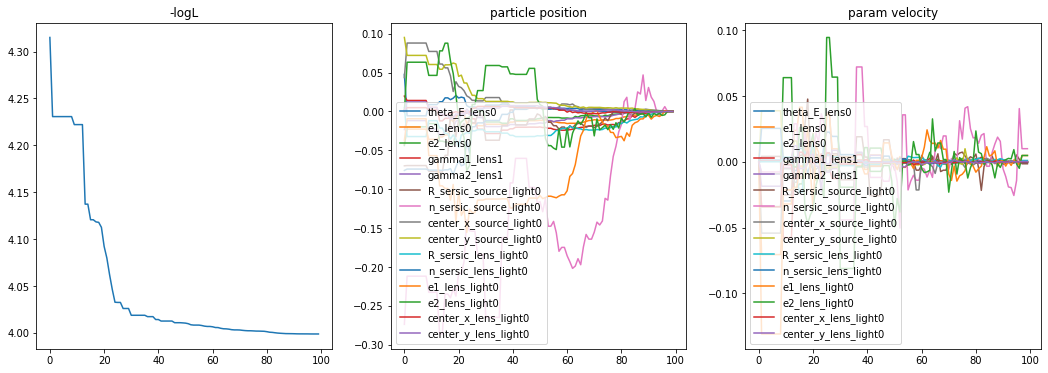

<Figure size 432x288 with 0 Axes>

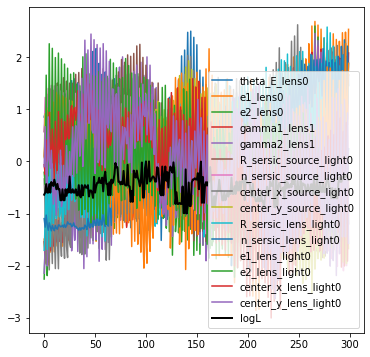

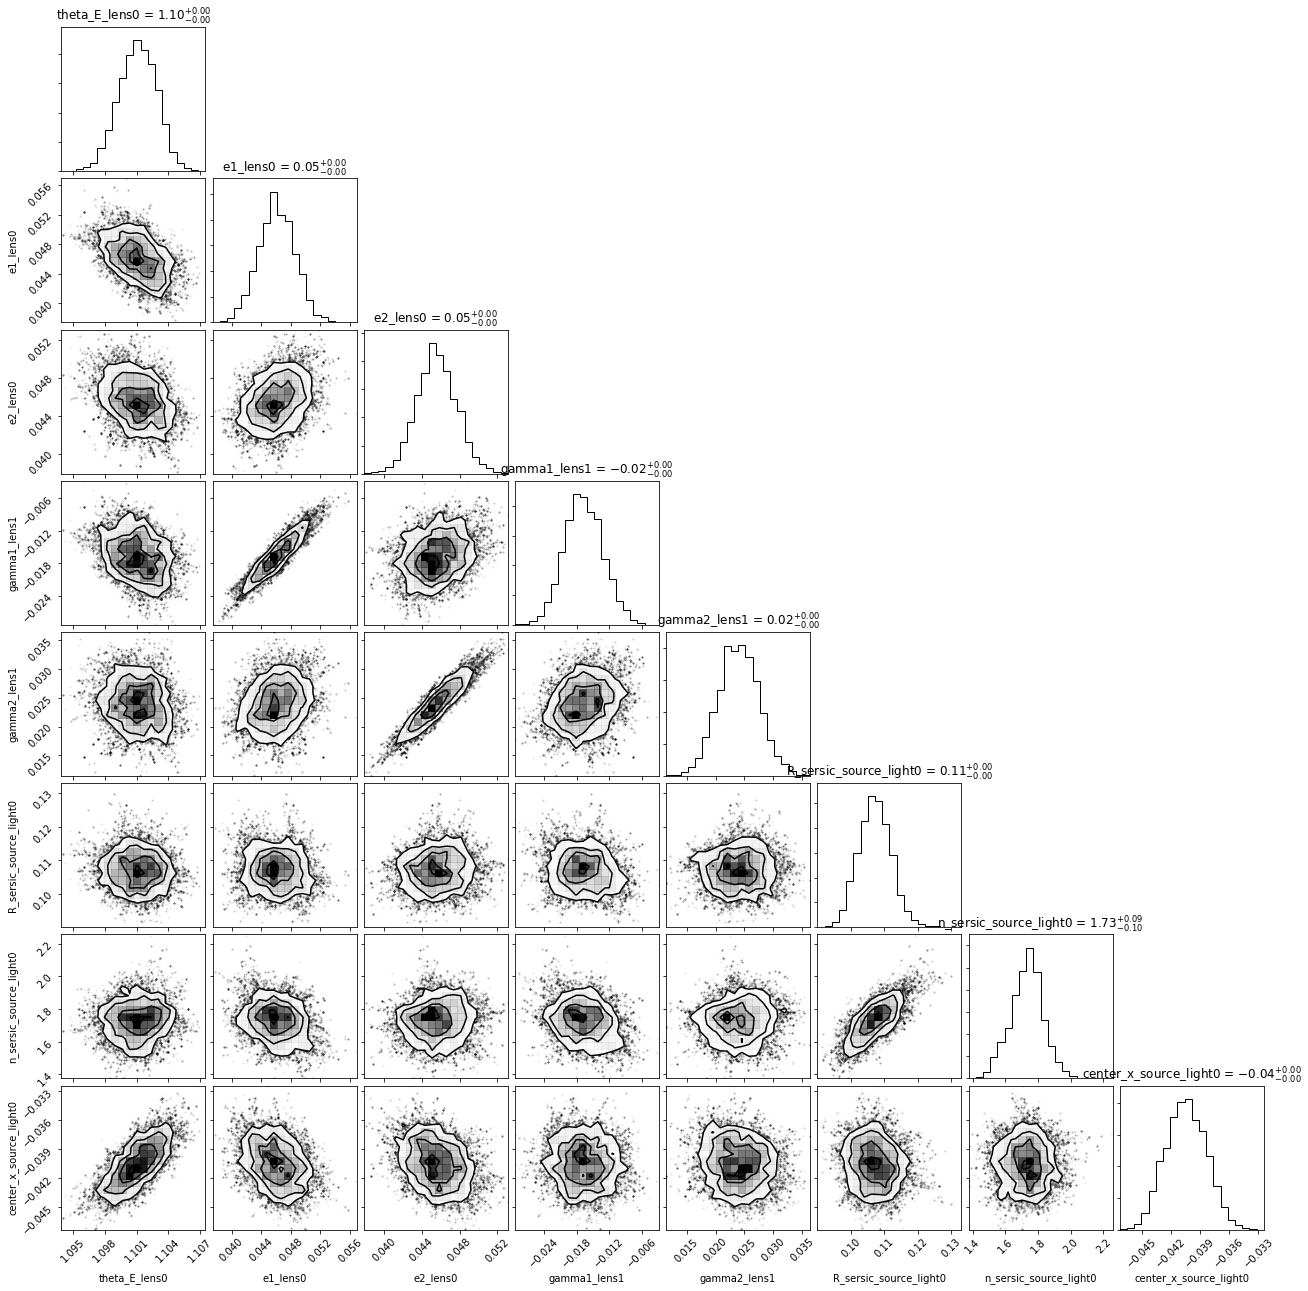

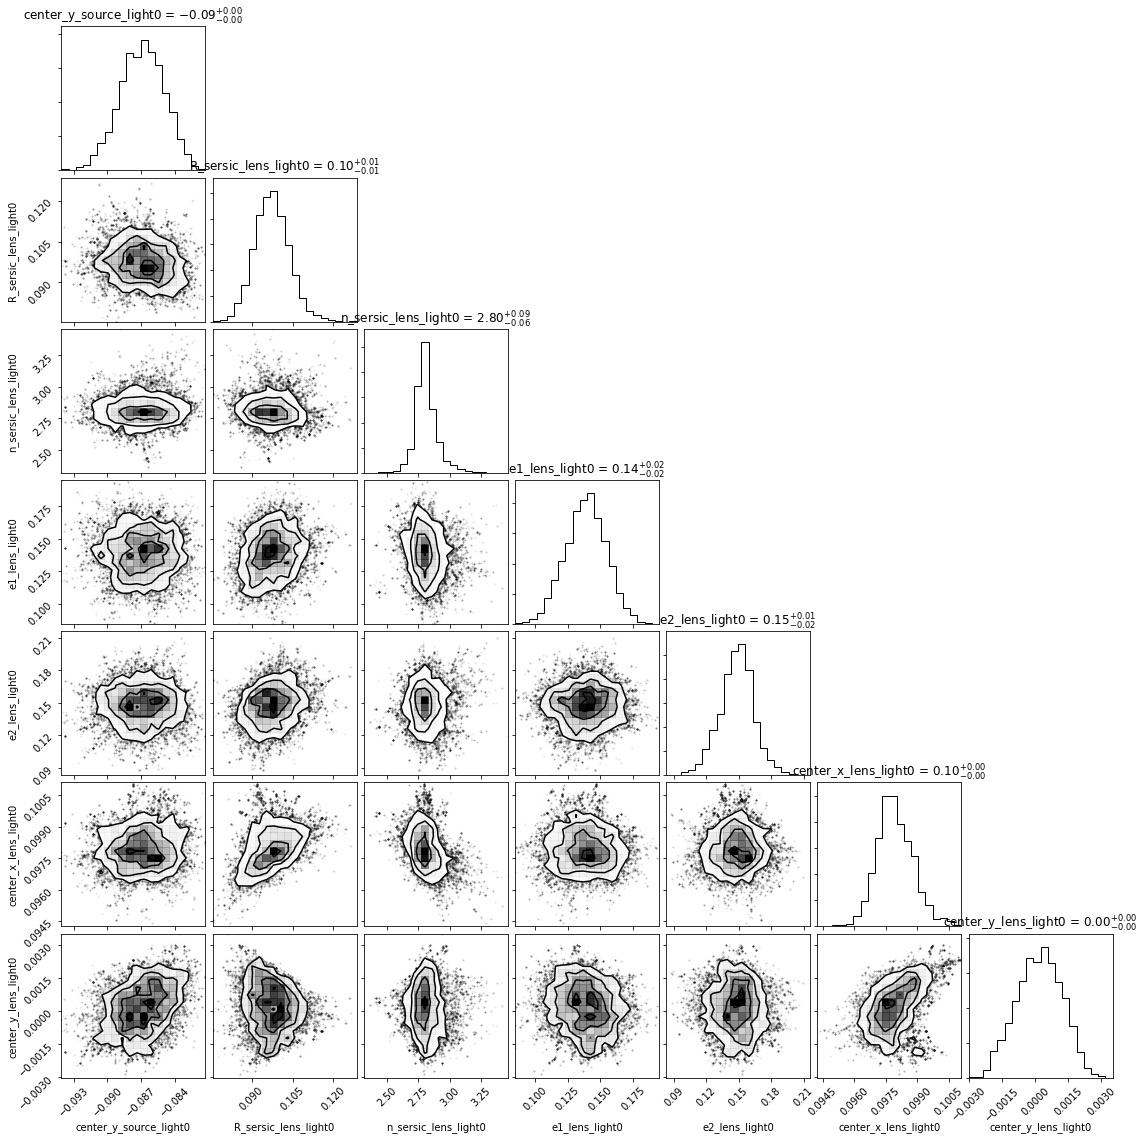

In [17]:
from lenstronomy.Plots import chain_plot

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner
if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
        plot.show()
        plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)